In [63]:
import mne
import matplotlib.pyplot as plt
import numpy as np

In [64]:
epochs = mne.read_epochs('A01T_epo.fif')

Reading e:\19_BCIexperiment\02_CodeTest\MNE_TEST\A01T_epo.fif ...
    Found the data of interest:
        t =    -500.00 ...    3500.00 ms
        0 CTF compensation matrices available
Not setting metadata
Not setting metadata
288 matching events found
No baseline correction applied
0 projection items activated


In [65]:
left_data = epochs['769'].get_data()
right_data = epochs['770'].get_data()
foot_data = epochs['771'].get_data()
tongue_data = epochs['772'].get_data()

In [66]:
left_data.shape

(72, 22, 1001)

In [67]:
from matplotlib import mlab
from scipy import signal
def psd(trials,NFFT,Fs):
    '''
    计算每一个trials的PSD功率谱密度
    
    Parameters
    ————————————————
    trials : 3d-array (trials x channels x samples)
        the EEG signal
    
    Returns
    ______________
    trial_PSD : 3d-array (trials x channels x PSD)
        the PSD for each trials
    freqs : list of floats
        the frequency for which the psd was computed (useful for plotting later)  

    '''
    ntrials = trials.shape[0]
    nchannels = trials.shape[1]

    #尝试计算一个PSD，查看PSD的数据长度
    (a,b) = mlab.psd(trials[0,0,:],NFFT=NFFT,Fs=Fs)
    npsdsamples = len(b)

    trials_psd = np.zeros((ntrials,nchannels,npsdsamples))

    #iterate over trials ans channels
    for trial in range(ntrials):
        for ch in range(nchannels):
            #caculate the psd 
            (freqs,PSD) = signal.welch(trials[trial,ch,:],nperseg = NFFT,fs=Fs)
            trials_psd[trial,ch,:] = PSD.ravel()

    return trials_psd,freqs

In [68]:
left_psd,freq = psd(left_data,NFFT=512,Fs=250)
right_psd,freq = psd(right_data,NFFT=512,Fs=250)


In [69]:
def plt_plot(PSD_data_c1,PSD_data_c2,freqs,ch_names,ch_idx,freq_range=[0,30]):
    plt.figure(figsize=(12,5))
    for i in range(len(ch_names)):
        ax = plt.subplot(1, 3, i+1, frameon = False)
        plt.plot(freqs,np.mean(PSD_data_c1[:,ch_idx[i],:],axis=0),label='c1')
        plt.plot(freqs,np.mean(PSD_data_c2[:,ch_idx[i],:],axis=0),label='c2')
        plt.title(ch_names[i]+'  psd')
        plt.xlim(freq_range[0],freq_range[1])
       
    plt.show()


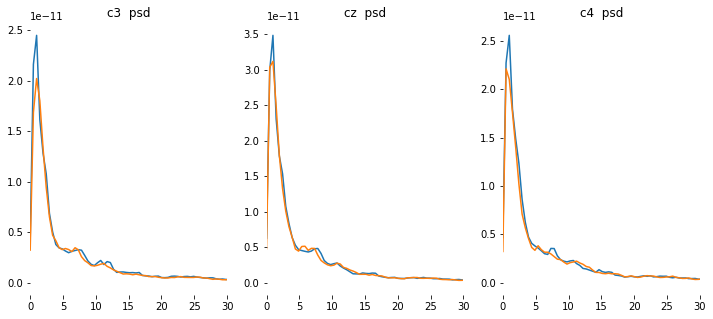

In [70]:
plt_plot(left_psd,right_psd,freq,['c3','cz','c4'],[7,9,11])


In [71]:
def band_pass(trials,lo,hi,sample_rate):
    '''
    为信号设计及使用带通滤波器

    Parameters
    ————————————————————————
    trials : 3d-array (trials x channels x samples)
        the eeg signal
    lo : float
        Lower frequency bound (in hz)
    hi : float
        Upper frequency bound (in hz)
    sample_rate : float
        Sample rate of the signal (in hz)

    Returns:
    ————————————————————————
    trials_filt : 3d-array (trials x channels x samples)
        The bandpass signal
    '''

    a , b = signal.iirfilter(6,[lo/(sample_rate/2.0) , hi/(sample_rate/2.0)]) 
    
    #为每一个trial的数据应用该滤波器
    ntrials = trials.shape[0]
    trials_filter = np.zeros(trials.shape)
    print('trials_filter shape ',trials_filter.shape)

    for i in range(ntrials):
        trials_filter[i,:,:] = signal.filtfilt(a,b,trials[i,:,:],axis=1)

    return trials_filter


In [72]:
left_data_filt = band_pass(left_data,8,15,sample_rate=250)
right_data_filt = band_pass(right_data,8,15,sample_rate=250)

trials_filter shape  (72, 22, 1001)
trials_filter shape  (72, 22, 1001)


In [73]:
left_filt_psd,freq = psd(left_data_filt,NFFT=512,Fs=250)
right_filt_psd,freq = psd(right_data_filt,NFFT=512,Fs=250)

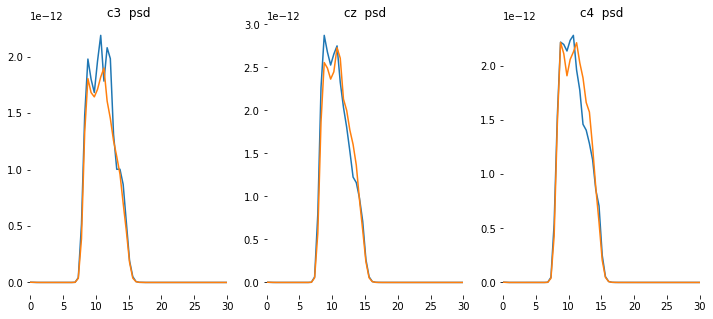

In [74]:
plt_plot(left_filt_psd,right_filt_psd,freq,['c3','cz','c4'],[7,9,11])

In [75]:
def logvar(trials):
    '''
    计算每一个trial的方差variance
    '''

    return np.log(np.var(trials,axis=2))

In [76]:
left_var = logvar(left_data_filt)
right_var = logvar(right_data_filt)



In [77]:
left_var.shape

(72, 22)

In [78]:
def plot_logvar(left_trials,right_trials):
    '''
    画出每一个通道的log-var成分 
    '''

    plt.figure(figsize = (12,5))
    
    nchannels = left_trials.shape[1]

    x0 = np.arange(nchannels)
    x1 = np.arange(nchannels) + 0.4
    print(x0.shape) 
    y0 = np.mean(left_trials,axis=0)
    y1 = np.mean(right_trials,axis=0)

    print(y0.shape)

    plt.bar(x0,y0,width=0.3,color='b')
    plt.bar(x1,y1,width=0.25,color='r')
    
    plt.xlim(-0.5,nchannels+0.5)

    plt.gca().yaxis.grid(True)
    plt.title('log-var of each channel / compoment')
    plt.xlabel('channels / compoment')
    plt.ylabel('log-var')




(22,)
(22,)


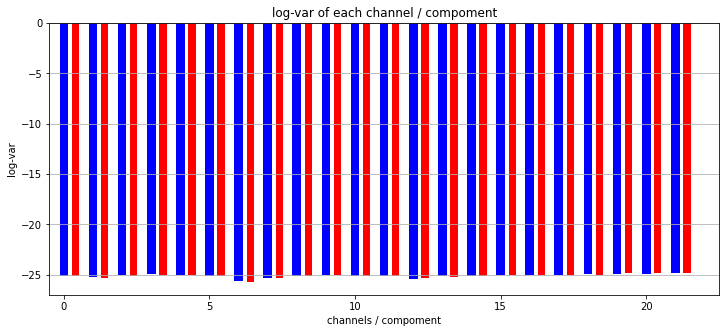

In [79]:
plot_logvar(left_var,right_var)

In [80]:
from numpy import linalg

def conv(trials):
    '''计算每一个trial的协方差,返回他们的平均值'''
    ntrials = trials.shape[0]
    nsamples = trials.shape[2]
    convs = [(trials[i,:,:].dot(trials[i,:,:].T) / nsamples) for i in range(ntrials)]
    return np.mean(convs,axis=0)

def whitening(sigma):
    '''计算白化矩阵  的搭配协方差的特征值以及特征矩阵'''
    # u 特征向量    l 特征值
    u,l,_ = linalg.svd(sigma)
    
    # P = u * (l**-0.5)
    return u.dot(np.diag(l**-0.5))

def csp(left_trials,right_trials):
    '''
    计算CSP的投影矩阵W
    '''
    conv_l = conv(left_trials)
    print('conv_l :',conv_l[0])
    conv_r = conv(right_trials)

    P = whitening(conv_l + conv_r)
    B,rr,_ = linalg.svd(P.T.dot(conv_r).dot(P))
    print('rr',rr)
    C,ll,_ = linalg.svd(P.T.dot(conv_l).dot(P))
    print('ll',ll)

    W = P.dot(B)

    return W

def apply_mix(W,trials):
    ntrials = trials.shape[0]
    trials_csp = np.zeros(trials.shape)
    for i in range(ntrials):
        trials_csp[i,:,:] = W.T.dot(trials[i,:,:])
    return trials_csp





In [81]:
W = csp(left_data_filt,right_data_filt)

left_csp = apply_mix(W,left_data_filt)
right_csp = apply_mix(W,right_data_filt)

conv_l : [1.32211440e-11 1.10536878e-11 1.27529088e-11 1.35623507e-11
 1.28198606e-11 1.14871582e-11 5.76053029e-12 8.43382214e-12
 1.07560685e-11 1.19445668e-11 1.13555519e-11 9.76030543e-12
 7.56096464e-12 6.18199572e-12 8.39274137e-12 9.23250341e-12
 9.11376005e-12 8.05492057e-12 5.82471116e-12 6.87848579e-12
 6.62277634e-12 4.40078342e-12]
rr [0.6518728  0.6101537  0.60674387 0.55357421 0.54189639 0.53099126
 0.52325173 0.5216547  0.51454931 0.50571312 0.49881685 0.4980183
 0.49611547 0.48714295 0.47778578 0.46706416 0.45764271 0.45148962
 0.4464743  0.4317758  0.34201131 0.31327738]
ll [0.68672262 0.65798869 0.5682242  0.5535257  0.54851038 0.54235729
 0.53293584 0.52221422 0.51285705 0.50388453 0.5019817  0.50118315
 0.49428688 0.48545069 0.4783453  0.47674827 0.46900874 0.45810361
 0.44642579 0.39325613 0.3898463  0.3481272 ]


In [82]:
left_csp_var = logvar(left_csp)
right_csp_var = logvar(right_csp)

print(left_csp_var.shape)

(72, 22)


(22,)
(22,)


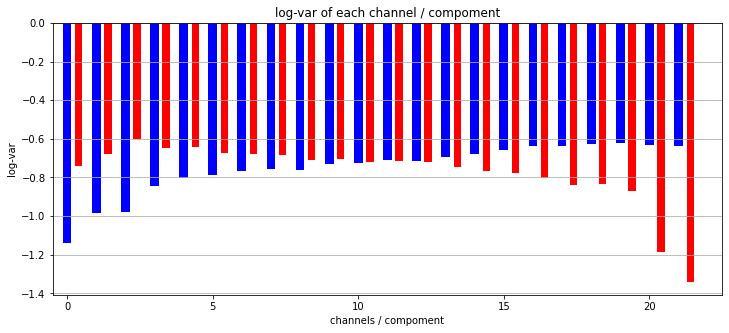

In [83]:
plot_logvar(left_csp_var,right_csp_var)

In [84]:
left_csp_psd,freq = psd(left_csp,NFFT=512,Fs=250)
right_csp_psd,freq = psd(right_csp,NFFT=512,Fs=250)

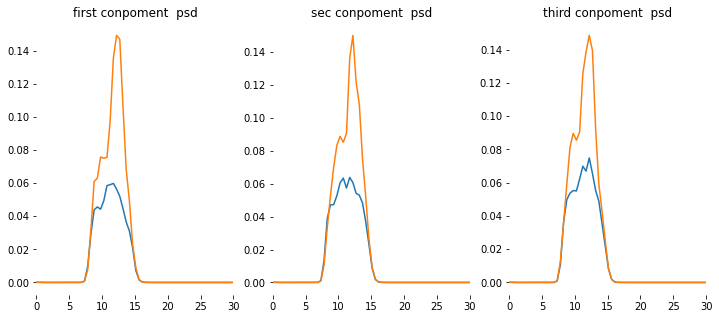

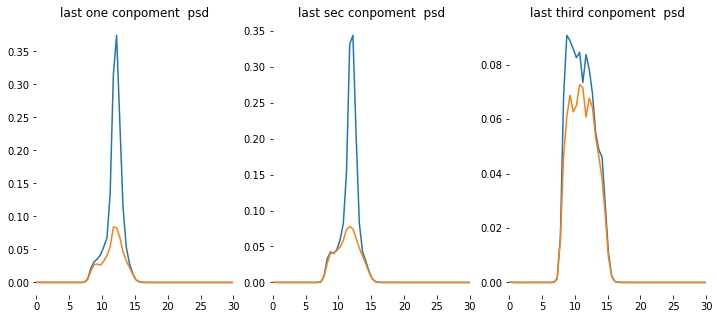

In [85]:
plt_plot(left_csp_psd,right_csp_psd,freq,['first conpoment','sec conpoment','third conpoment'],[0,1,2])
plt_plot(left_csp_psd,right_csp_psd,freq,['last one conpoment','last sec conpoment','last third conpoment'],[-1,-2,-3])

### 可视化训练数据

(72, 2)


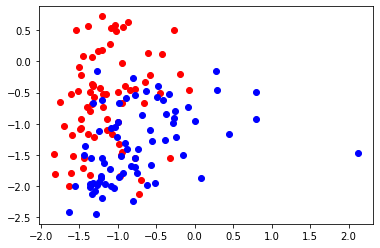

In [86]:
left_feat = left_csp_var[:,[0,-1]]
right_feat = right_csp_var[:,[0,-1]]
print(left_feat.shape)

plt.scatter(left_feat[:,0],left_feat[:,1],c='r')
plt.scatter(right_feat[:,0],right_feat[:,1],c='b')
plt.show()

### mY CSP

In [87]:
def cal_norm_covMatrix(X):
    R = X.dot(X.T)
    R_norm = R / X.shape[1]
    return R_norm

def cal_whitening_P(Rc):
    U,lambd,_ = np.linalg.svd(Rc)
    #print(lambd)
    #print('U特征向量矩阵为:\n',U)
    
    #print('RC value is :',Rc[0])
    #print('reverse Rc value is :',U.dot(np.diag(lambd).dot(U.T))[0])

    P = np.diag(lambd**(-0.5)).dot(U.T)
    #print('定义矩阵P为:\n',P)
    return P

def cal_W(left_trials,right_trials):
    ntrials = left_trials.shape[0]
    nchannels = left_trials.shape[1]

    Ra = np.zeros((ntrials,nchannels,nchannels))
    for i in range(ntrials):
        Ra[i,:,:] = cal_norm_covMatrix(left_trials[i,:,:])
    Ra_avg = np.mean(Ra,axis=0)
    #print('Ra_avg',Ra_avg[0])

    Rb = np.zeros((ntrials,nchannels,nchannels))
    for i in range(ntrials):
        Rb[i,:,:] = cal_norm_covMatrix(right_trials[i,:,:])
    Rb_avg = np.mean(Rb,axis=0)

    Rc = Ra_avg + Rb_avg

    P = cal_whitening_P(Rc)


    Sa = P.dot(Ra_avg.dot(P.T))
    Sb = P.dot(Rb_avg.dot(P.T))

    D1,lambd_a,_ = np.linalg.svd(Sa)
    #D2,lambd_b,_ = np.linalg.svd(Sb)
    print('两类的特征值lambda:\n',lambd_a)
    #print('两类的特征值lambdb:\n',lambd_b)

    #print('Sa value is ',Sa[0])
    #reverse_sa = D1.dot(np.diag(lambd_a).dot(D1.T))
    #print('reverse Sa value is ',reverse_sa[0])
    
    #print('D1 value is \n',D1[0:5,[0,1]])
    #print('D2 value is \n',D2[0:5,[-1,-2]])

    #print('Sb value is ',Sb[0])
    #print('Sb * u ',Sb.dot(D1[:,0]))
    #print('lambd * u ',lambd_b[-1] * D1[:,0])

    print('Sb value is ',Sb[0:6,0:6])
    reverse_sb = D1.dot(np.diag(1-lambd_a).dot(D1.T))
    print('reverse Sb value is ',reverse_sb[0:6,0:6])

    print('------------------------')
    #取第一行和最后一行
    W = D1.T.dot(P)

    return W


In [88]:
import MY_bcilib as mybci

my_W = mybci.cal_W(left_data_filt,right_data_filt)

两类的特征值lambda:
 [0.68672262 0.65798869 0.5682242  0.5535257  0.54851038 0.54235729
 0.53293584 0.52221422 0.51285705 0.50388453 0.5019817  0.50118315
 0.49428688 0.48545069 0.4783453  0.47674827 0.46900874 0.45810361
 0.44642579 0.39325613 0.3898463  0.3481272 ]
Sb value is  [[ 0.5014882  -0.00897735  0.01066424 -0.01239076 -0.00794538  0.00693932]
 [-0.00897735  0.4721888  -0.052438    0.02009808  0.02931415 -0.08088225]
 [ 0.01066424 -0.052438    0.47580427  0.04398194 -0.00887798 -0.00621806]
 [-0.01239076  0.02009808  0.04398194  0.49529296 -0.00876071  0.01787705]
 [-0.00794538  0.02931415 -0.00887798 -0.00876071  0.50008171  0.01674636]
 [ 0.00693932 -0.08088225 -0.00621806  0.01787705  0.01674636  0.46051077]]
reverse Sb value is  [[ 0.5014882  -0.00897735  0.01066424 -0.01239076 -0.00794538  0.00693932]
 [-0.00897735  0.4721888  -0.052438    0.02009808  0.02931415 -0.08088225]
 [ 0.01066424 -0.052438    0.47580427  0.04398194 -0.00887798 -0.00621806]
 [-0.01239076  0.02009808  0

In [89]:
my_left_csp = mybci.apply_mix(my_W,left_data_filt)
my_right_csp = mybci.apply_mix(my_W,right_data_filt)

(22,)
(22,)


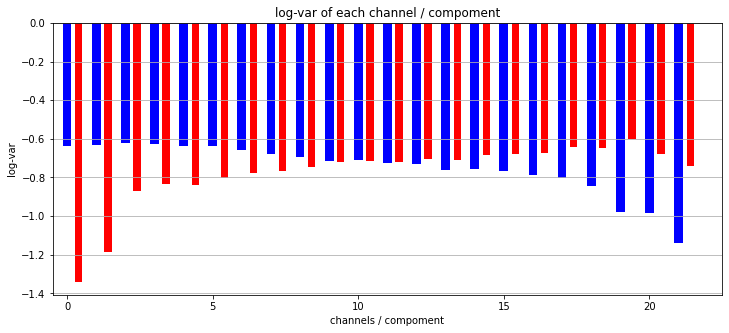

In [91]:
my_left_csp_var = logvar(my_left_csp)
my_right_csp_var = logvar(my_right_csp)
plot_logvar(my_left_csp_var,my_right_csp_var)